Visco-plastic 2-D mantle convection problem in a square box
===========================================================

To illustrate the changes necessary to incorporate a visco-plastic rheology, which is
more representative of deformation within Earth's mantle and lithosphere, we examine a case
from Tosi et al. (2015), a benchmark study intended to form a straightforward extension to
Blankenbach et al. (1989) - the example that was considered in our first tutorial. Aside
from the viscosity and reference Rayleigh Number ($Ra_{0}=10^2$), all other aspects of this
case are identical to that first tutorial.

The viscosity field, $\mu$, is calculated as the harmonic mean between a linear component,
$\mu_{\text{lin}}$, and a nonlinear, plastic component, $\mu_{\text{plast}}$, which is dependent
on the strain-rate, as follows:

$$    \mu(T,z,\dot \epsilon) = 2 \Biggl(\frac{1}{\mu_{\text{lin}(T,z)}} + \frac{1}{\mu_{\text{plast}(\dot\epsilon)}} \Biggr)^{-1}. $$

The linear part is given by an Arrhenius law (the so-called Frank-Kamenetskii approximation):

$$ \mu_{\text{lin}(T,z)} = \exp(-\gamma_{T}T + \gamma_{z}z),$$

where $\gamma_{T}=\ln(\Delta\mu_T)$ and $\gamma_{z}=\ln(\Delta\mu_z)$ are parameters controlling the total
viscosity contrast due to temperature and depth, respectively. The nonlinear component is given by:

$$ \mu_{\text{plast}}(\dot\epsilon) = \mu^{\star} + \frac{\sigma_{y}}{\sqrt{\dot\epsilon : \dot\epsilon}} $$

where $\mu^\star$ is a constant representing the effective viscosity at high stresses and $\sigma_{y}$ is the yield stress.
The denominator of the second term represents the second invariant of the strain-rate tensor.
The visco-plastic flow law leads to linear viscous deformation at low stresses and plastic deformation
at stresses that exceed $\sigma_{y}$, with the decrease in viscosity limited by the choice of $\mu^\star$.

This example
------------

In this example, we simulate incompressible convection, for a material with a rheology
like that described above. We specify $Ra_{0}=10^2$.
The model is heated from below (T = 1.0), cooled from the top (T=0)
in an enclosed 2-D Cartesian box (i.e. free-slip mechanical boundary
conditions on all boundaries).

As with all examples, the first step is to import the gadopt module, which
provides access to Firedrake and associated functionality.

In [1]:
from gadopt import *

We next set up the mesh, function spaces, and specify functions to hold our solutions,
identically to our previous tutorials.

In [2]:
nx, ny = 40, 40  # Number of cells in x and y directions.
mesh = UnitSquareMesh(nx, ny, quadrilateral=True)  # Square mesh generated via firedrake
mesh.cartesian = True

boundary = get_boundary_ids(mesh)

V = VectorFunctionSpace(mesh, "CG", 2)  # Velocity function space (vector)
W = FunctionSpace(mesh, "CG", 1)  # Pressure function space (scalar)
Q = FunctionSpace(mesh, "CG", 2)  # Temperature function space (scalar)
Z = MixedFunctionSpace([V, W])  # Mixed function space.

z = Function(Z)  # A field over the mixed function space Z.
u, p = split(z)  # Returns symbolic UFL expression for u and p
z.subfunctions[0].rename("Velocity")
z.subfunctions[1].rename("Pressure")

We next provide the important constants for this problem, which includes those associated
with our rheological formulation, and define our approximation. Given that viscosity
depends on temperature here, we setup and initialise our temperature earlier than in the previous tutorials.

In [3]:
X = SpatialCoordinate(mesh)
T = Function(Q, name="Temperature")
T.interpolate((1.0-X[1]) + (0.05*cos(pi*X[0])*sin(pi*X[1])))

gamma_T, gamma_Z = Constant(ln(10**5)), Constant(ln(10))  # temperature and depth sensitivity of viscosity
mu_star, sigma_y = Constant(0.001), Constant(1.0)
epsilon = sym(grad(u))  # Strain-rate
epsii = sqrt(inner(epsilon, epsilon) + 1e-10)  # 2nd invariant (with tolerance to ensure stability)
mu_lin = exp(-gamma_T*T + gamma_Z*(1 - X[1]))  # linear component of rheological formulation
mu_plast = mu_star + (sigma_y / epsii)  # plastic component of rheological formulation
mu = (2. * mu_lin * mu_plast) / (mu_lin + mu_plast)  # harmonic mean

Now that we have defined our expression for the viscosity field
we can pass this to our approximation.

In [4]:
Ra = Constant(100)  # Rayleigh number
approximation = BoussinesqApproximation(Ra, mu=mu)

As with the previous examples, we set up a *Timestep Adaptor*,
for controlling the time-step length (via a CFL
criterion) as the simulation advances in time. For the latter,
we specify the initial time, initial timestep $\Delta t$, and number of
timesteps. Given the low Ra, a steady-state tolerance is also specified,
allowing the simulation to exit when a steady-state has been achieved.
The steady-state tolerance specified here is tight, and can be increased
to speed up the simulation, as required.

In [5]:
time = 0.0  # Initial time
delta_t = Constant(1e-6)  # Initial time-step
timesteps = 20000  # Maximum number of timesteps
t_adapt = TimestepAdaptor(delta_t, u, V, maximum_timestep=0.1, increase_tolerance=1.5)
steady_state_tolerance = 1e-9  # Used to determine if solution has reached a steady state.

This problem has a constant pressure nullspace, handled identically to our
previous tutorials.

In [6]:
Z_nullspace = create_stokes_nullspace(Z, closed=True, rotational=False)

/home/firedrake/firedrake/src/firedrake/firedrake/functionspaceimpl.py:160: FutureWarning: The 'subfunctions' property is deprecated for function spaces, please use the 'subspaces' property instead
  warnings.warn("The 'subfunctions' property is deprecated for function spaces, please use the "


Boundary conditions are next specified.

In [7]:
stokes_bcs = {
    boundary.bottom: {'uy': 0},
    boundary.top: {'uy': 0},
    boundary.left: {'ux': 0},
    boundary.right: {'ux': 0},
}

temp_bcs = {
    boundary.bottom: {'T': 1.0},
    boundary.top: {'T': 0.0},
}

We next set up our output, in VTK format. To do so, we create the output file
and specify the output_frequency in timesteps.
We also open a file for logging and calculate our diagnostic outputs.

In [8]:
output_file = VTKFile("output.pvd")
output_frequency = 50

plog = ParameterLog('params.log', mesh)
plog.log_str("timestep time dt maxchange u_rms u_rms_surf ux_max nu_top nu_base energy avg_t")

gd = GeodynamicalDiagnostics(z, T, boundary.bottom, boundary.top)

We can now setup and solve the variational problem, for both the energy and Stokes equations,
passing in the approximation configured above. Note that given viscosity varies with both
space and time, we can no longer specify the keyword constant_jacobian = True. We also make
the solver aware of this spatial and temporal variation using the mu keyword. The latter is
particularly relevant for iterative solvers and preconditioners that can make use of this
information to improve convergence.

In [9]:
energy_solver = EnergySolver(T, u, approximation, delta_t, ImplicitMidpoint, bcs=temp_bcs)

stokes_solver = StokesSolver(z, T, approximation, bcs=stokes_bcs,
                             nullspace=Z_nullspace, transpose_nullspace=Z_nullspace)

Next, we initiate the time loop, which runs until a steady-state solution has been attained.

In [10]:
for timestep in range(0, timesteps):

    # Write output:
    if timestep % output_frequency == 0:
        output_file.write(*z.subfunctions, T)

    dt = t_adapt.update_timestep()
    time += dt

    # Solve Stokes sytem:
    stokes_solver.solve()

    # Temperature system:
    energy_solver.solve()

    # Compute diagnostics:
    energy_conservation = abs(abs(gd.Nu_top()) - abs(gd.Nu_bottom()))

    # Calculate L2-norm of change in temperature:
    maxchange = sqrt(assemble((T - energy_solver.T_old)**2 * dx))

    # Log diagnostics:
    plog.log_str(f"{timestep} {time} {float(delta_t)} {maxchange} "
                 f"{gd.u_rms()} {gd.u_rms_top()} {gd.ux_max(boundary.top)} {gd.Nu_top()} "
                 f"{gd.Nu_bottom()} {energy_conservation} {gd.T_avg()} ")

    # Leave if steady-state has been achieved:
    if maxchange < steady_state_tolerance:
        log("Steady-state achieved -- exiting time-step loop")
        break

Steady-state achieved -- exiting time-step loop


At the end of the simulation, once a steady-state has been achieved, we close our logging file
and checkpoint steady state temperature and Stokes solution fields to disk. These can later be
used to restart a simulation, if required.

In [11]:
plog.close()

with CheckpointFile("Final_State.h5", "w") as final_checkpoint:
    final_checkpoint.save_mesh(mesh)
    final_checkpoint.save_function(T, name="Temperature")
    final_checkpoint.save_function(z, name="Stokes")

We can visualise the final temperature field using Firedrake's
built-in plotting functionality.

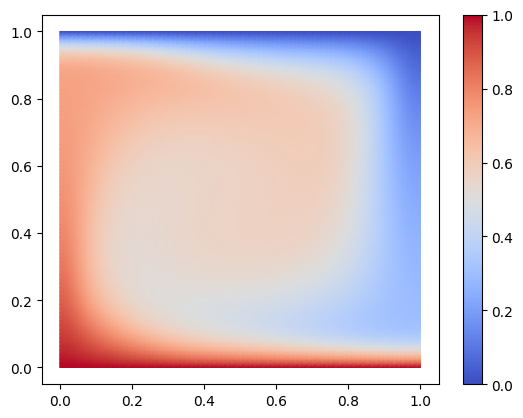

In [12]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
collection = tripcolor(T, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

The same can be done for the viscosity field, although that must
first be interpolated onto a function space, as the viscosity $\\mu$ is currently only specified in UFL.

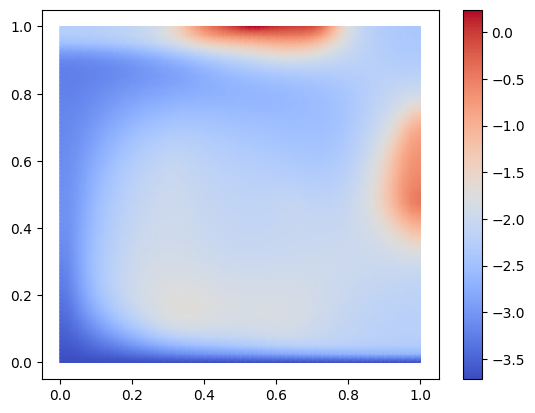

In [13]:
mu_field = Function(W, name="Viscosity")
mu_field.interpolate(ln(mu) / ln(10))
fig, axes = plt.subplots()
collection = tripcolor(mu_field, axes=axes, cmap='coolwarm')
fig.colorbar(collection);